In [9]:
import keras
import tensorflow as tf 
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.preprocessing import  LabelBinarizer
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras import applications
from tensorflow.keras.applications import ResNet50, ResNet50V2, DenseNet201, MobileNet, MobileNetV2
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import regularizers
from keras import optimizers
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input
from keras.models import Model, Sequential
from tensorflow.keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, Activation
from tensorflow.keras.layers import Dense, UpSampling2D, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Dropout
from keras.layers import Concatenate, SpatialDropout2D
from keras.datasets import cifar100
from keras.initializers import he_normal, random_normal
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
import keras.backend as K
from keras.utils import print_summary, to_categorical
from keras.utils import plot_model, np_utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
import os
import cv2
import random


In [10]:
#Load Cifar100 data
((x_train,y_train),(x_test,y_test))=cifar100.load_data()
x_val , y_val = x_train[40000:,:],y_train[40000:]
x_train , y_train = x_train[:40000,:],y_train[:40000]
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_val = x_val.reshape(x_val.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
x_train = x_train.astype('float32')/255.0
x_val = x_val.astype('float32')/255
x_test = x_test.astype('float32')/255.0


In [11]:
#One hot encoding label (Y)
Y_train = np_utils.to_categorical(y_train, 100)
Y_val = np_utils.to_categorical(y_val, 100)
Y_test = np_utils.to_categorical(y_test, 100)

In [12]:
x_train.shape

(40000, 32, 32, 3)

In [41]:
# CIFAR-100 labels list
labelNames = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

In [13]:
#hyper-parametter
num_classes = 100
batch_size = 64
epochs = 15

        


In [14]:
basemodel = DenseNet201(include_top=False, weights='imagenet', input_shape=(128,128,3), classes=num_classes)

74842112/74836368 [==============================] - 1s 0us/step


In [15]:
#model
model = Sequential()
model.add(UpSampling2D((2,2))) #change size input to fit basemodel
model.add(UpSampling2D((2,2))) #change size input to fit basemodel
model.add(basemodel)
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='softmax'))
model.build((None, 32, 32, 3))

In [16]:
model.layers[3].trainable = False 

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) multiple                  0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 multiple                  0         
_________________________________________________________________
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  983552    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  5

In [18]:
#callback set-up
lr_reducer      = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1),
                                    cooldown=0, patience=10, min_lr=0.5e-6)
early_stopper   = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=20)
model_checkpoint= ModelCheckpoint("weights/DenseNet-BC-100-12-CIFAR100.h5", monitor="val_acc", save_best_only=True,
                                  save_weights_only=True)

callbacks=[lr_reducer, early_stopper, model_checkpoint]

In [19]:
optimizer = Adam(lr=1e-4) # Using Adam instead of SGD to speed up training
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [20]:
#Augmentation
datagen = ImageDataGenerator(rotation_range=15,
                               width_shift_range=5./32,
                               height_shift_range=5./32)  


In [21]:
datagen.fit(x_train, seed=0)

In [22]:
train_flow = datagen.flow(x_train, Y_train, batch_size)

In [23]:
H = model.fit_generator(train_flow,
                    epochs=epochs,
                    
                    validation_data=(x_val, Y_val),
                    callbacks = callbacks)
                    

Train for 625 steps, validate on 10000 samples
Epoch 1/15
625/625 [==============================] - 191s 305ms/step - loss: 1.9423 - accuracy: 0.5149 - val_loss: 0.9526 - val_accuracy: 0.7283
Epoch 2/15
625/625 [==============================] - 158s 252ms/step - loss: 0.8291 - accuracy: 0.7584 - val_loss: 0.8602 - val_accuracy: 0.7508
Epoch 3/15
625/625 [==============================] - 157s 252ms/step - loss: 0.5435 - accuracy: 0.8364 - val_loss: 0.8080 - val_accuracy: 0.7752
Epoch 4/15
625/625 [==============================] - 157s 251ms/step - loss: 0.3937 - accuracy: 0.8783 - val_loss: 0.8084 - val_accuracy: 0.7774
Epoch 5/15
625/625 [==============================] - 158s 253ms/step - loss: 0.2891 - accuracy: 0.9092 - val_loss: 0.8740 - val_accuracy: 0.7696
Epoch 6/15
625/625 [==============================] - 158s 253ms/step - loss: 0.2244 - accuracy: 0.9279 - val_loss: 0.9485 - val_accuracy: 0.7666
Epoch 7/15
625/625 [==============================] - 158s 253ms/step - loss:

In [24]:
model.save('ducluu_model_cifar100.h5')

'ducluu_model_cifar100.h5'

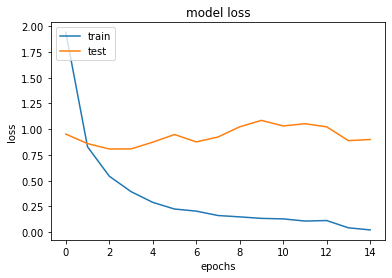

In [25]:
#visualize loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

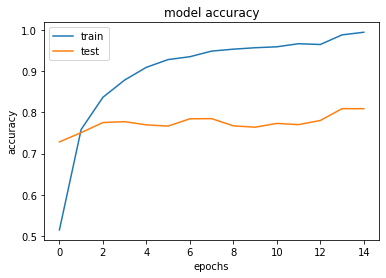

In [33]:
#visualize accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [28]:
score = model.evaluate(x_test, Y_test)
print('accuracy: ',score[1])

10000/10000 [==============================] - 20s 2ms/sample - loss: 0.8723 - accuracy: 0.8161
accuracy:  0.8161


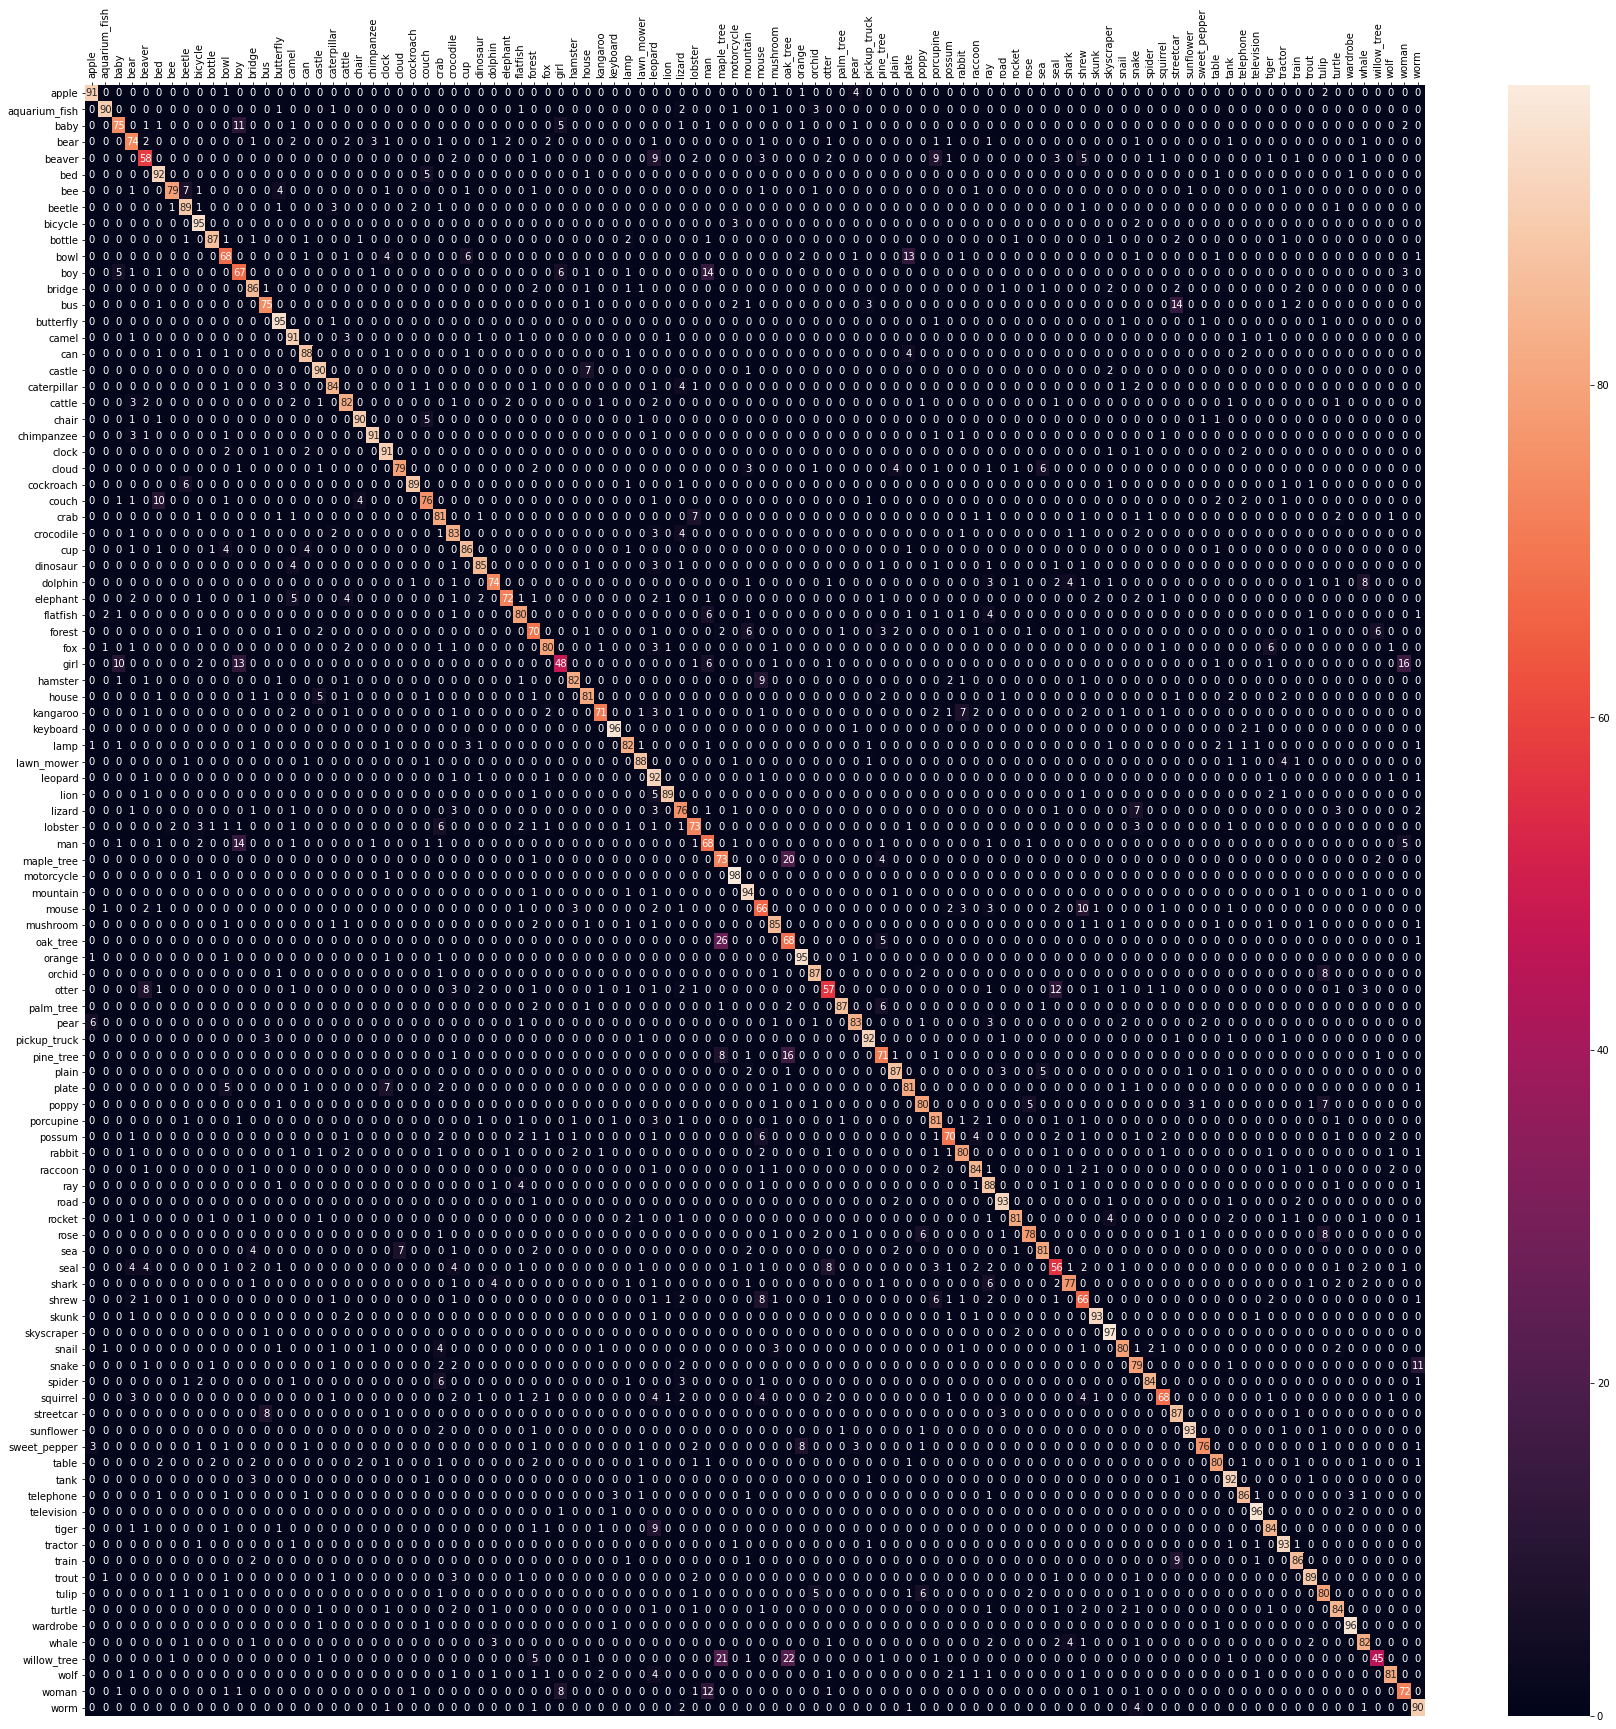

In [44]:
#confusion matrix

pred = model.predict(x_test,batch_size=64)

cm = confusion_matrix(np.argmax(Y_test, axis = 1),np.argmax(pred, axis = 1))
df_cm = pd.DataFrame(cm, index = [i for i in labelNames],
                  columns = [i for i in labelNames])

fig, ax = plt.subplots()
ax.xaxis.tick_top()
fig.set_size_inches((30,30))
sn.heatmap(df_cm,annot=True,ax=ax)

In [45]:
#class-wise accuracy
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels[1]

preds = model.predict(x_test)
print(classification_report(rounded_labels, np.argmax(preds, axis=1), target_names=labelNames))

               precision    recall  f1-score   support

        apple       0.89      0.91      0.90       100
aquarium_fish       0.94      0.90      0.92       100
         baby       0.78      0.75      0.77       100
         bear       0.70      0.74      0.72       100
       beaver       0.67      0.58      0.62       100
          bed       0.80      0.92      0.86       100
          bee       0.94      0.79      0.86       100
       beetle       0.82      0.89      0.85       100
      bicycle       0.84      0.95      0.89       100
       bottle       0.94      0.87      0.90       100
         bowl       0.72      0.68      0.70       100
          boy       0.61      0.67      0.64       100
       bridge       0.78      0.86      0.82       100
          bus       0.83      0.75      0.79       100
    butterfly       0.84      0.95      0.89       100
        camel       0.79      0.91      0.85       100
          can       0.88      0.88      0.88       100
       ca